Predicting the Outcome of NBA Games Using Machine Learning

Data found from https://www.kaggle.com/nathanlauga/nba-games/notebooks for NBA games from 2004-2020. Kaggle data was extrated from official NBA website.

Medium Blog here: https://jyduan-8715.medium.com/predicting-the-outcome-of-nba-games-using-machine-learning-676a62549040

Github here: https://github.com/jduannn?tab=repositories

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics as sm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
df = pd.read_csv("games.csv")
df.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2020-12-19,12000047,Final,1610612753,1610612766,2020,1610612753,120.0,0.433,0.792,0.425,23.0,50.0,1610612766,117.0,0.444,0.864,0.439,21.0,52.0,1
1,2020-12-19,12000048,Final,1610612764,1610612765,2020,1610612764,99.0,0.427,0.625,0.295,24.0,45.0,1610612765,96.0,0.402,0.647,0.326,18.0,51.0,1
2,2020-12-19,12000049,Final,1610612763,1610612737,2020,1610612763,116.0,0.400,0.744,0.396,21.0,43.0,1610612737,117.0,0.422,0.837,0.297,24.0,47.0,0
3,2020-12-18,12000039,Final,1610612754,1610612755,2020,1610612754,107.0,0.371,0.692,0.262,19.0,45.0,1610612755,113.0,0.533,0.629,0.355,23.0,48.0,0
4,2020-12-18,12000040,Final,1610612761,1610612748,2020,1610612761,105.0,0.380,0.737,0.356,27.0,37.0,1610612748,117.0,0.534,0.741,0.514,30.0,51.0,0


In [ ]:
print(df.shape, "\n")
df.info()

(23520, 21) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23520 entries, 0 to 23519
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     23520 non-null  object 
 1   GAME_ID           23520 non-null  int64  
 2   GAME_STATUS_TEXT  23520 non-null  object 
 3   HOME_TEAM_ID      23520 non-null  int64  
 4   VISITOR_TEAM_ID   23520 non-null  int64  
 5   SEASON            23520 non-null  int64  
 6   TEAM_ID_home      23520 non-null  int64  
 7   PTS_home          23421 non-null  float64
 8   FG_PCT_home       23421 non-null  float64
 9   FT_PCT_home       23421 non-null  float64
 10  FG3_PCT_home      23421 non-null  float64
 11  AST_home          23421 non-null  float64
 12  REB_home          23421 non-null  float64
 13  TEAM_ID_away      23520 non-null  int64  
 14  PTS_away          23421 non-null  float64
 15  FG_PCT_away       23421 non-null  float64
 16  FT_PCT_away       23421 no

In [ ]:
# remove 99 games which had null data
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23421 entries, 0 to 23519
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     23421 non-null  object 
 1   GAME_ID           23421 non-null  int64  
 2   GAME_STATUS_TEXT  23421 non-null  object 
 3   HOME_TEAM_ID      23421 non-null  int64  
 4   VISITOR_TEAM_ID   23421 non-null  int64  
 5   SEASON            23421 non-null  int64  
 6   TEAM_ID_home      23421 non-null  int64  
 7   PTS_home          23421 non-null  float64
 8   FG_PCT_home       23421 non-null  float64
 9   FT_PCT_home       23421 non-null  float64
 10  FG3_PCT_home      23421 non-null  float64
 11  AST_home          23421 non-null  float64
 12  REB_home          23421 non-null  float64
 13  TEAM_ID_away      23421 non-null  int64  
 14  PTS_away          23421 non-null  float64
 15  FG_PCT_away       23421 non-null  float64
 16  FT_PCT_away       23421 non-null  float6

In [ ]:
df[df.duplicated()].shape # check for duplicated rows

(0, 21)

In [ ]:
# look at summary statistics
# remove scientific notation for readability
df.describe(include=np.number).apply(lambda s: s.apply(lambda x: format(x, 'g'))).transpose()
# 36 point game min seems suspicious; noting it for further analysis

,count,mean,std,min,25%,50%,75%,max
GAME_ID,23421,2.16536e+07,5.54224e+06,1.03e+07,2.06007e+07,2.11004e+07,2.16003e+07,5.19001e+07
HOME_TEAM_ID,23421,1.61061e+09,8.64468,1.61061e+09,1.61061e+09,1.61061e+09,1.61061e+09,1.61061e+09
VISITOR_TEAM_ID,23421,1.61061e+09,8.65597,1.61061e+09,1.61061e+09,1.61061e+09,1.61061e+09,1.61061e+09
SEASON,23421,2010.99,4.87646,2003,2007,2011,2015,2020
TEAM_ID_home,23421,1.61061e+09,8.64468,1.61061e+09,1.61061e+09,1.61061e+09,1.61061e+09,1.61061e+09
PTS_home,23421,102.283,12.9501,36,93,102,111,168
FG_PCT_home,23421,0.459854,0.0567699,0.25,0.42,0.459,0.5,0.684
FT_PCT_home,23421,0.758158,0.100325,0.143,0.696,0.765,0.826,1
FG3_PCT_home,23421,0.355531,0.114312,0,0.283,0.355,0.429,1
AST_home,23421,22.5361,5.15108,6,19,22,26,47


In [ ]:
print("Points")
pt = list(df.PTS_home.unique())
pt.sort()
print(pt)
# 36 seems to be a significant outlier
  # game was cancelled due to condensation on the court

i = df[df.PTS_home==36].index
df = df.drop(i)

Points
[36.0, 59.0, 60.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 154.0, 157.0, 158.0, 161.0, 168.0]


In [ ]:
# our analysis looks at the differentials for the games
# add differentials into the df
df["PTS_dif"] = df.PTS_home - df.PTS_away
df["AST_dif"] = df.AST_home - df.AST_away
df["REB_dif"] = df.REB_home - df.REB_away
df["FG_dif"] = df.FG_PCT_home - df.FG_PCT_away
df["FG3_dif"] = df.FG3_PCT_home - df.FG3_PCT_away

 Basic data processing is done at this point. EDA can be found here along with github code: https://jyduan-8715.medium.com/exploratory-data-analysis-of-home-team-advantage-in-the-nba-2004-2020-58c9922a8744

Modelling assumptions going forward will use conclusions from EDA.

In [ ]:
diff_df = df[["PTS_dif","AST_dif","REB_dif","FG_dif","FG3_dif"]]  # df for differentials
print(diff_df.corr()) # seems to be some correlation between these variables

          PTS_dif   AST_dif   REB_dif    FG_dif   FG3_dif
PTS_dif  1.000000  0.599197  0.447098  0.769660  0.498235
AST_dif  0.599197  1.000000  0.187092  0.578864  0.362940
REB_dif  0.447098  0.187092  1.000000  0.296268  0.107408
FG_dif   0.769660  0.578864  0.296268  1.000000  0.430453
FG3_dif  0.498235  0.362940  0.107408  0.430453  1.000000


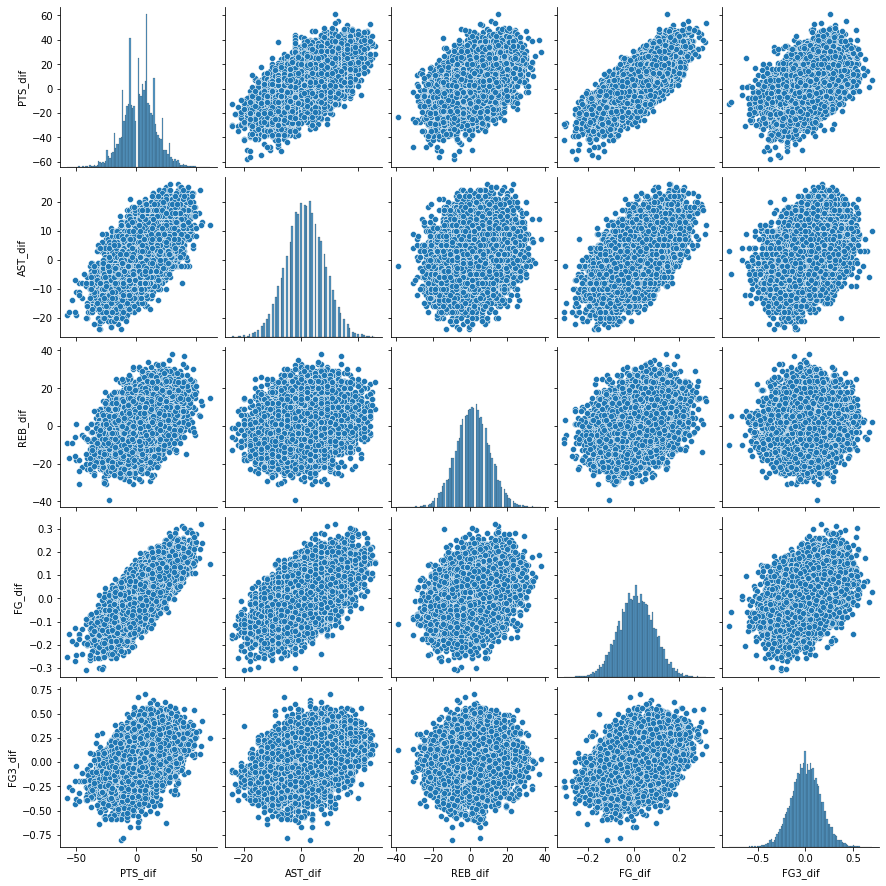

In [ ]:
sns.pairplot(diff_df)
plt.show()
# AST, REB, FG, and FG3 seem to have correlation with PTS
# All the variables are approxiamtely normally distirbuted, aside from PTS
# FG is slightly autocorrelated with AST

In [ ]:
# Model 1: Mulitple Regression using all AST, FG, and FG3 to determine point differentials
df1 = df[["PTS_dif","AST_dif","FG_dif","FG3_dif"]]

X = df1.iloc[:, 1:]
y = df1.iloc[:, 0]

# Split 70 train/30 test with random state = 2020
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

# Check shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16394, 3)
(16394,)
(7026, 3)
(7026,)


In [ ]:
model = LinearRegression()

# fit the model using training data
model.fit(X_train,y_train)

# predicted outcome based on model for test set
y_pred = model.predict(X_test)

# Baseline Model accuracy
print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2)) 
print("Root mean squared error =", round(math.sqrt(sm.mean_squared_error(y_test, y_pred)), 2)) 

# use R2 
# use MAE, bc less sensitive to outliers compared to RMSE


R2 score = 0.65
Mean absolute error = 6.21
Root mean squared error = 7.81


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


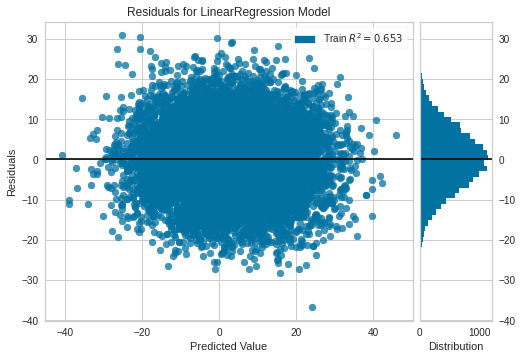

In [ ]:
# Residuals look decent, could be more spread out and random
# Distirbution looks very good, very close to normal

from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)
visualizer.poof()

In [ ]:
# Model 1A: Multiple regression including REB_dif
df2 = df[["PTS_dif","AST_dif","REB_dif","FG_dif","FG3_dif"]]

X = df2.iloc[:, 1:]
y = df2.iloc[:, 0]

# Split 70 train/30 test with random state = 2020
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

model = LinearRegression()

# fit the model using training data
model.fit(X_train,y_train)

# predicted outcome based on model for test set
y_pred = model.predict(X_test)

print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2)) 
print("Root mean squared error =", round(math.sqrt(sm.mean_squared_error(y_test, y_pred)), 2)) 

R2 score = 0.71
Mean absolute error = 5.65
Root mean squared error = 7.15


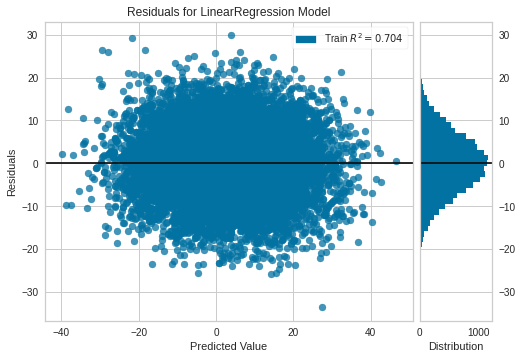

In [ ]:
# Model 1A
# Residual looks similar
# Distribution looks really good
# R2 lower, so we should keep REB
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)
visualizer.poof()

In [ ]:
# Model 1B: Predicted games that are not close (5 PTS differential or more)

df3 = df[["PTS_dif","AST_dif","REB_dif","FG_dif","FG3_dif"]]
df3 = df3[(df3["PTS_dif"] >= 5) | (df3["PTS_dif"] <= -5)]

X = df3.iloc[:, 1:]
y = df3.iloc[:, 0]

# Split 70 train/30 test with random state = 2020
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

model = LinearRegression()

# fit the model using training data
model.fit(X_train,y_train)

# predicted outcome based on model for test set
y_pred = model.predict(X_test)

print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2)) 
print("Root mean squared error =", round(math.sqrt(sm.mean_squared_error(y_test, y_pred)), 2)) 

R2 score = 0.75
Mean absolute error = 5.83
Root mean squared error = 7.35


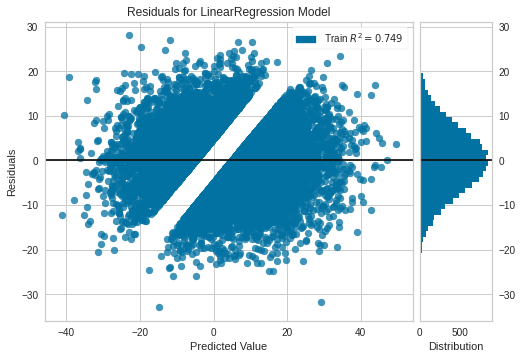

In [ ]:
# Model 1B
# Residuals look different bc we exclude games within 4 points
# Distribution looks good

visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)
visualizer.poof()

In [ ]:
# Model 1B: Predicted games that are close (within 4 PTS)

df3 = df[["PTS_dif","AST_dif","REB_dif","FG_dif","FG3_dif"]]
df3 = df3[(df3["PTS_dif"] < 5) & (df3["PTS_dif"] > -5)]

X = df3.iloc[:, 1:]
y = df3.iloc[:, 0]

# Split 70 train/30 test with random state = 2020
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

model = LinearRegression()

# fit the model using training data
model.fit(X_train,y_train)

# predicted outcome based on model for test set
y_pred = model.predict(X_test)

print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2)) 
print("Root mean squared error =", round(math.sqrt(sm.mean_squared_error(y_test, y_pred)), 2)) 

R2 score = 0.09
Mean absolute error = 2.35
Root mean squared error = 2.66


Part 2: Using Logistic Regression to predict outcome of a game

In [ ]:
df4 = df[["HOME_TEAM_WINS","AST_dif","REB_dif","FG_dif","FG3_dif"]]
# HOME_TEAM_WINS is the variable we are trying to predict
# 1 represents home win, 0 represents away team win
# Differentials are in the perspective of the home team

contingencyTable = pd.crosstab(index=[df4["AST_dif"], df4["REB_dif"], df4["FG_dif"], df4["FG3_dif"]], columns=df["HOME_TEAM_WINS"])
print(contingencyTable)

HOME_TEAM_WINS                  0  1
AST_dif REB_dif FG_dif FG3_dif      
-24.0   -13.0   -0.159 -0.085   1  0
        -6.0    -0.156 -0.325   1  0
        -1.0    -0.173 -0.107   1  0
-23.0   -7.0    -0.167 -0.107   1  0
        -1.0    -0.113 -0.221   1  0
...                            .. ..
 25.0    14.0    0.107  0.178   0  1
                 0.222  0.283   0  1
         18.0    0.095  0.083   0  1
 26.0    9.0     0.157  0.179   0  1
         23.0    0.153  0.176   0  1

[23420 rows x 2 columns]


In [ ]:
# Model 2: Logistic regression using lbfgs
X = df4.iloc[:, 1:]
y = df4.iloc[:, 0]

# Split 70 train/30 test with random state = 2020
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

model = LogisticRegression()

# fit the model using training data
model.fit(X_train,y_train)

# predicted outcome based on model for test set
y_pred = model.predict(X_test)

dummy_clf = DummyClassifier(strategy="most_frequent") # Establish baseline accuracy
dummy_clf.fit(X_train, y_train)
dummy_clf.predict(X_test)
print("baseline:", dummy_clf.score(X_test,y_test))

print("accuracy:", sm.accuracy_score(y_test, y_pred)) # Display accuracy of model predictions

print(classification_report(y_test,y_pred))

baseline: 0.5962140620552234
accuracy: 0.8363222317107885
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      2837
           1       0.86      0.87      0.86      4189

    accuracy                           0.84      7026
   macro avg       0.83      0.83      0.83      7026
weighted avg       0.84      0.84      0.84      7026



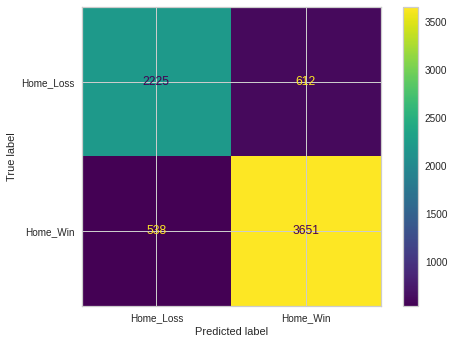

In [ ]:
Labels = ['Home_Loss', 'Home_Win']
sm.plot_confusion_matrix(model, X_test, y_test,display_labels=Labels,values_format = '.5g')
plt.show()

Other Classifiers

In [ ]:
df6 = df[["HOME_TEAM_WINS","AST_dif","REB_dif","FG_dif","FG3_dif"]]

scaler = MinMaxScaler(feature_range=(0, 1))
normalizedData = scaler.fit_transform(df6)
cols = ["HOME_TEAM_WINS","AST_dif","REB_dif","FG_dif","FG3_dif"]
normalizedData = pd.DataFrame(normalizedData, columns=cols)
print(normalizedData.head())

   HOME_TEAM_WINS  AST_dif   REB_dif    FG_dif   FG3_dif
0             1.0     0.52  0.480519  0.472843  0.524000
1             1.0     0.60  0.428571  0.530351  0.512667
2             0.0     0.42  0.454545  0.455272  0.599333
3             0.0     0.40  0.467532  0.231629  0.471333
4             0.0     0.42  0.324675  0.244409  0.428000


In [ ]:
X = normalizedData.iloc[:, 1:]
y = normalizedData.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, stratify=y, random_state=2020)

In [ ]:
# Bagging

model_bagging = BaggingClassifier(n_estimators=10, random_state=2020)  # by default "None" is using a DT classifier

model_bagging.fit(X_train, y_train) # fitting the model

pred_bagging = model_bagging.predict(X_test)  # getting predicted via Bagging

print("Accuracy:", accuracy_score(y_test, pred_bagging))

Accuracy: 0.8095644748078565


In [ ]:
# Random Forest

model_rf = RandomForestClassifier(n_estimators=200, random_state=2020)

model_rf.fit(X_train, y_train)  # fitting the model

predict_rf = model_rf.predict(X_test) # getting predicted via RandomForest

print("Accuracy:", accuracy_score(y_test, predict_rf))

Accuracy: 0.8212354113293482


In [ ]:
rf_features = pd.DataFrame(zip(X_train.columns, model_rf.feature_importances_), columns=["Features","Importance"]) # feature importance

rf_features = rf_features.sort_values(by='Importance', ascending=False) # sort by descending importance

print(rf_features.iloc[:3]) # print top 3 features for RandomForest

  Features  Importance
2   FG_dif    0.458570
3  FG3_dif    0.233906
0  AST_dif    0.158380


In [ ]:
# AdaBoost Classification

base_est = DecisionTreeClassifier (max_depth=4) # use dt as base estimator

ada_boost = AdaBoostClassifier(base_est, n_estimators=200, random_state=42, learning_rate=0.05)

model_ab = ada_boost.fit(X_train, y_train) # fitting the model

predict_ab = model_ab.predict(X_test) # getting predicted via AdaBoost

print("Accuracy:", accuracy_score(y_test, predict_ab))

Accuracy: 0.8309137489325363


In [ ]:
ab_features = pd.DataFrame(zip(X_train.columns, model_ab.feature_importances_), columns=["Features","Importance"])

ab_features = ab_features.sort_values(by='Importance', ascending=False)

print(ab_features.iloc[:3]) # print top 3 features for AdaBoost

  Features  Importance
2   FG_dif    0.418697
3  FG3_dif    0.259305
1  REB_dif    0.172727


In [ ]:
# Voting Ensemble for Classification

rfClf = RandomForestClassifier(n_estimators=200, max_depth=4)

dtClf = DecisionTreeClassifier(max_depth=4)

svmClf = SVC(probability=True)

logClf = LogisticRegression()

voteclf = VotingClassifier(estimators = [('rf',rfClf), ('dt',dtClf), ('svm',svmClf), ('log', logClf)], voting='soft')

voteclf.fit(X_train, y_train)

voteclf_pred = voteclf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, voteclf_pred))

Accuracy: 0.8326216908625107


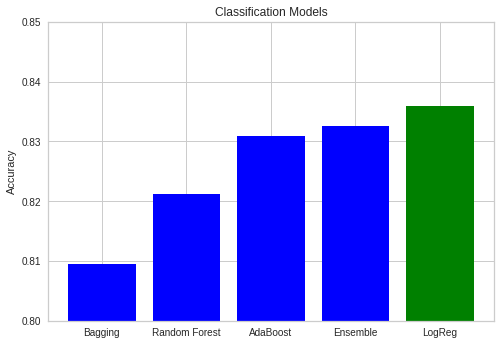

In [ ]:
# Bar graph for model accuracy

models = ('Bagging', 'Random Forest', 'AdaBoost', 'Ensemble', 'LogReg')
y_pos = np.arange(len(models))
accuracy = [accuracy_score(y_test, pred_bagging), accuracy_score(y_test, predict_rf),
            accuracy_score(y_test, predict_ab), accuracy_score(y_test, voteclf_pred),0.836]

plt.bar(y_pos, accuracy, color=['blue','blue','blue','blue','green'], align='center')
plt.xticks(y_pos, models)
plt.ylim(bottom=0.8,top=0.85)
plt.ylabel('Accuracy')
plt.title('Classification Models')

plt.show()


Final Logistic Regression Model

In [ ]:
# LogReg with Normalized & Resampled Data

df7 = df[["HOME_TEAM_WINS","AST_dif","REB_dif","FG_dif","FG3_dif"]]

scaler = MinMaxScaler(feature_range=(0, 1))
normalizedData = scaler.fit_transform(df7)
cols = ["HOME_TEAM_WINS","AST_dif","REB_dif","FG_dif","FG3_dif"]
normalizedData = pd.DataFrame(normalizedData, columns=cols)

X = normalizedData.iloc[:, 1:]
y = normalizedData.iloc[:, 0]

# Split 70 train/30 test with random state = 2020
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

# Use Random Over & Under Sampling to make the training data outcomes closer to 50/50
over = RandomOverSampler(sampling_strategy=0.75)
# resample the training data by oversampling observations that were home loss
X_train_res, y_train_res = over.fit_resample(X_train, y_train)

# resample the training data by undersampling obserbations that were home win
under = RandomUnderSampler(sampling_strategy=0.9)
# fit and apply the transform
X_train_res, y_train_res = under.fit_resample(X_train, y_train)
# result is 9/10 ratio of home loss to home wins 
# as opposed to the prior 4:6 ratio

model = LogisticRegression()

# fit the model using resampled data
model.fit(X_train_res, y_train_res)

# predicted outcome based on model for test set
y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

         0.0       0.78      0.83      0.80      2837
         1.0       0.88      0.84      0.86      4189

    accuracy                           0.84      7026
   macro avg       0.83      0.83      0.83      7026
weighted avg       0.84      0.84      0.84      7026



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


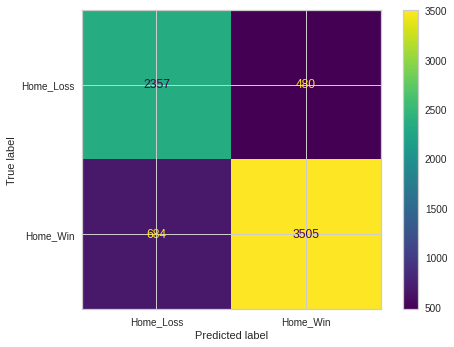

In [ ]:
Labels = ['Home_Loss', 'Home_Win']
sm.plot_confusion_matrix(model, X_test, y_test,display_labels=Labels,values_format = '.5g')
plt.show()

In [ ]:
model.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [ ]:
# Grid search to to fine tune model parameters

df8 = df[["HOME_TEAM_WINS","AST_dif","REB_dif","FG_dif","FG3_dif"]]

X = df8.iloc[:, 1:]
y = df8.iloc[:, 0]

# Split 70 train/30 test with random state = 2020
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

parameters = [{'penalty' : ['l1', 'l2','none'], 'C' : np.logspace(-4,4,20),
               'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
               'max_iter' : [100, 1000, 2500]}]

grid_clf = GridSearchCV(model, param_grid = parameters, scoring = 'accuracy', cv=3, verbose=True, n_jobs=-1)
grid_clf.fit(X_train, y_train)

y_pred = grid_clf.predict(X_test)

print(classification_report(y_test,y_pred))

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 107 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 490 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 914 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1312 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 2440 tasks      | elapsed:  7.3min


              precision    recall  f1-score   support

           0       0.80      0.79      0.80      2837
           1       0.86      0.87      0.86      4189

    accuracy                           0.84      7026
   macro avg       0.83      0.83      0.83      7026
weighted avg       0.84      0.84      0.84      7026



[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:  8.4min finished


In [ ]:
grid_clf.best_estimator_
print("accuracy:", sm.accuracy_score(y_test, y_pred))

accuracy: 0.8360375747224594
